# Song lyrics - Part 1: Overview

This is first of several notebooks examining the song lyrics dataset. This notebook explores some basic properties of the dataset, while also tidying up the data for analysis in the following notebooks.

### Imports

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
plt.style.use('seaborn')
import seaborn as sns
sns.set(font_scale=2)

### Select songs with lyrics

In [2]:
df = pd.read_csv('songs.csv', low_memory=False)
df = df[~df.song_darklyrics.isnull()]
df = df[df.song_darklyrics.str.strip().apply(len) > 0]

### Reduced dataset

For lyrical analyses the data is reduced to just a column of lyrics (which will become the feature vector upon some transformation to a quantitative representation) for each song and columns for the most popular genres (the target/label vectors). These genres are determined as the subset of genres which appear at least once in isolation, i.e. not accompanied by any other genre, and which appear in some minimum percentage of songs. For example, the "black" metal label can appear on bands with or without other genres, but a label like "atmospheric" never appears on its own despite being fairly popular, usually because it is more of an adjective to denote subgenres like atmospheric black metal; thus "black" will be kept but not "atmospheric". This reduces the genres to a more manageable set: five genres if the minimum occurrence requirement is set to 10%, and thirteen if set to 1%.

A five-genre set would be more robust to training, but leaves quite a few holes in the label space because doom metal, metalcore, folk metal, and many other fairly popular genres are being omitted that may not be covered by any of the five labels. The larger label set covers just about all the most important genres, but because eight of them occur in fewer than 10% of all songs, they will force greater class imbalance which will adversely affect binary classification later on. For the sake of comparison both datasets are saved here, but the rest of this notebook only looks at the 1% dataset. Each dataset will be saved in its raw form and in a truncated (ML-ready) form containing only the lyrics and genre columns.

In [3]:
def process_genre(genre):
    # Find words (including hyphenated words) not in parentheses
    out = re.findall('[\w\-]+(?![^(]*\))', genre.lower())
    out = [s for s in out if s != 'metal']
    return out


song_genres = df.band_genre.apply(process_genre)
genres = sorted(set(song_genres.sum()))
genre_cols = [f'genre_{genre}' for genre in genres]
for genre, col in zip(genres, genre_cols):
    df[col] = song_genres.apply(lambda x: int(genre in x))

In [4]:
def get_top_genres(data, min_pct):
    isolated = (data.sum(axis=1) == 1)
    isolated_cols = sorted(set(data[isolated].idxmax(axis=1)))
    top_cols = [col for col in isolated_cols if data[col][isolated].mean() >= min_pct]
    top_genres = [re.sub(r"^genre\_", "", col) for col in top_cols]
    return top_genres

In [5]:
top_genres = get_top_genres(df[genre_cols], 0.1)
print(top_genres)
df_r = df.copy()
drop_cols = [col for col in df.columns if ('genre_' in col) and (re.sub(r"^genre\_", "", col) not in top_genres)]
df_r.drop(drop_cols, axis=1, inplace=True)
df_r.to_csv('songs-10pct.csv', index=False)

# Only lyrics and genre are relevant for ML later
df_ml = pd.DataFrame(index=range(df.shape[0]), columns=['lyrics'] + top_genres)
df_ml['lyrics'] = df['song_darklyrics'].reset_index(drop=True)
df_ml[top_genres] = df[[f"genre_{genre}" for genre in top_genres]].reset_index(drop=True)
df_ml.to_csv('songs-ml-10pct.csv', index=False)

['black', 'death', 'heavy', 'power', 'thrash']


In [6]:
top_genres = get_top_genres(df[genre_cols], 0.01)
print(top_genres)
df_r = df.copy()
drop_cols = [col for col in df.columns if ('genre_' in col) and (re.sub(r"^genre\_", "", col) not in top_genres)]
df_r.drop(drop_cols, axis=1, inplace=True)
df_r.to_csv('songs-1pct.csv', index=False)

# Only lyrics and genre are relevant for ML later
df_ml = pd.DataFrame(index=range(df.shape[0]), columns=['lyrics'] + top_genres)
df_ml['lyrics'] = df['song_darklyrics'].reset_index(drop=True)
df_ml[top_genres] = df[[f"genre_{genre}" for genre in top_genres]].reset_index(drop=True)
df_ml.to_csv('songs-ml-1pct.csv', index=False)

['black', 'death', 'deathcore', 'doom', 'folk', 'gothic', 'grindcore', 'heavy', 'metalcore', 'power', 'progressive', 'symphonic', 'thrash']


# Basic lyrical properties

This section looks only at word counts. [Part 3](./lyrics2.ipynb) dives much deeper into evaluating lyrical complexity using various lexical diversity measures.

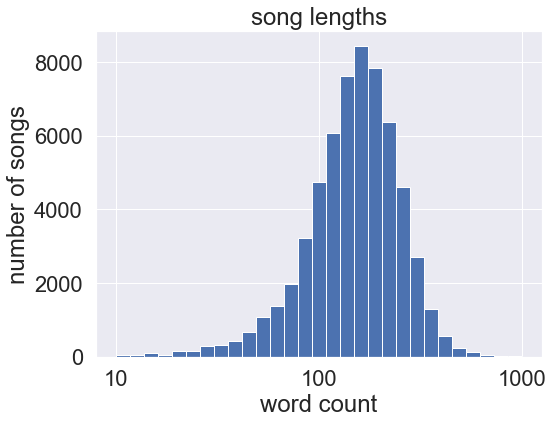

In [78]:
song_lengths = df_r.song_darklyrics.str.split().apply(len)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
song_lengths.hist(bins=np.logspace(1, 3, 30), ax=ax)
ax.set_xscale('log')
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_xlabel("word count")
ax.set_ylabel("number of songs")
ax.set_title("song lengths")
plt.show()

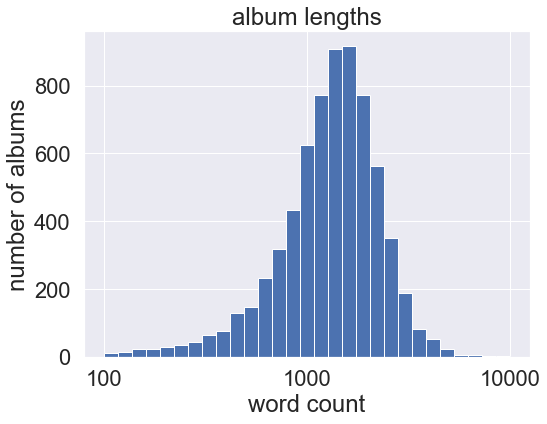

In [79]:
album_lyrics = df_r.groupby('album_name').song_darklyrics.sum()
album_lengths = album_lyrics.str.split().apply(len)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
album_lengths.hist(bins=np.logspace(2, 4, 30), ax=ax)
ax.set_xscale('log')
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_xlabel("word count")
ax.set_ylabel("number of albums")
ax.set_title("album lengths")
plt.show()

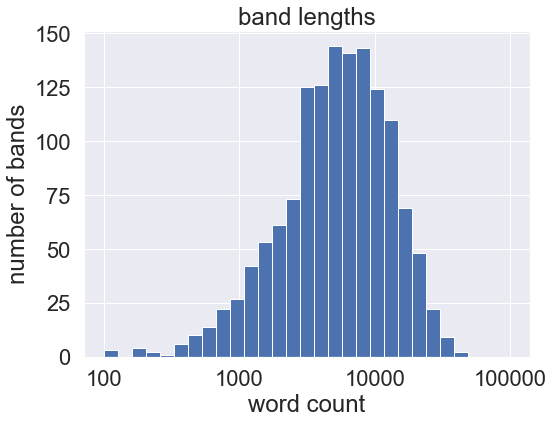

In [80]:
band_lyrics = df_r.groupby('band_name').song_darklyrics.sum()
band_lengths = band_lyrics.str.split().apply(len)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
band_lengths.hist(bins=np.logspace(2, 5, 30), ax=ax)
ax.set_xscale('log')
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_xlabel("word count")
ax.set_ylabel("number of bands")
ax.set_title("band lengths")
plt.show()

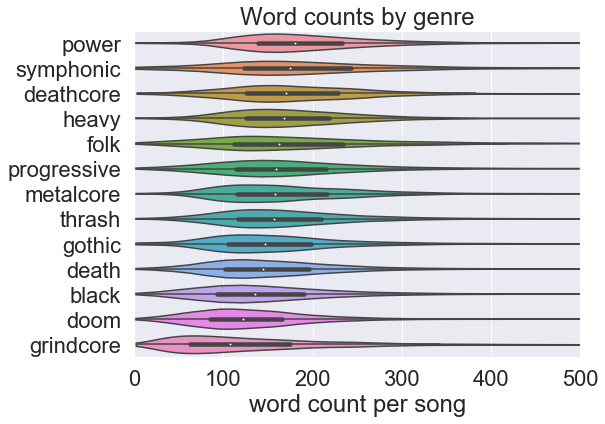

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
violindata = []
for genre in top_genres:
    df_genre = df[df[f"genre_{genre}"] == 1]
    violindata.append((genre, df_genre.song_darklyrics.str.split().apply(len).values))
violindata.sort(key=lambda x: -np.median(x[1]))
sns.violinplot(data=[x[1] for x in violindata], cut=0, orient='h')
ax.set_yticklabels([x[0] for x in violindata])
ax.set_xlim(0, 500)
ax.set_title("Word counts by genre")
ax.set_xlabel("word count per song")
plt.show()